## Species Simulated Shifts

This jupyter notebook contains the code for simulated species shifts figure 5

In [19]:
#Import the necessary packages
import geopandas as gpd
import xarray as xr
import numpy as np
#from scipy.stats import linregress
#import seaborn as sns
#from scipy.interpolate import interp1d as int1
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon, Point, MultiPolygon
#import shapefile
import random
#import cartopy
#import cartopy.crs as ccrs
#import pandas as pn
#import os
#import scipy
#import geoplot as gplt
#import geoplot.crs as gcrs

#import mapclassify as mc
#import matplotlib.colors
#from matplotlib import gridspec
#import random#

In [2]:
# Load EPU shapefile
LME_nogeo = gpd.read_file('/Users/nyelab/Downloads/LME66/LMEs66.shp', ignore_geometry=True)

In [3]:
# Load EPU shapefile
LME = gpd.read_file('/Users/nyelab/Downloads/LME66/LMEs66.shp')

In [4]:
LME_nogeo[LME_nogeo.LME_NAME == 'Northeast U.S. Continental Shelf']

,OBJECTID,LME_NUMBER,LME_NAME,GROUPING,ARCTIC,USLMES,Shape_Leng,Shape_Area,SUM_GIS_KM
11,12,7.0,Northeast U.S. Continental Shelf,None,None,Yes,131.060763,34.46993,322287.929835


In [5]:
# Select the specific LMEs
LME_Name = 'Northeast U.S. Continental Shelf'
neus_shp = LME[LME.LME_NAME == LME_Name].geometry[LME.OBJECTID[LME.LME_NAME == LME_Name].values[0] -1]

LME_Name = 'Gulf of Mexico'
gome_shp = LME[LME.LME_NAME == LME_Name].geometry[LME.OBJECTID[LME.LME_NAME == LME_Name].values[0] -1]

LME_Name = 'East Bering Sea'
ebes_shp = LME[LME.LME_NAME == LME_Name].geometry[LME.OBJECTID[LME.LME_NAME == LME_Name].values[0] -1]

In [6]:
#Load the climate velocity data for the selected LMEs
# NE US Continental Shelf
neus = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/LME_data_files/Northeast_US_Continental_Shelf_vcv.nc')
neus_h = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/LME_data_files/Northeast_US_Continental_Shelf_hcv_revised.nc')

In [7]:
# Gulf of Mexico
gome = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/LME_data_files/Gulf_of_Mexicovcv.nc')
gome_h = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/LME_data_files/Gulf_of_Mexicohcv_revised.nc')

In [8]:
# East Bering Sea
ebes = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/LME_data_files/East_Bering_Seavcv.nc')
ebes_h = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/LME_data_files/East_Bering_Seahcv.nc')

In [9]:
#Correction for vertical velocity
#(Initially missed this step in a few LMEs so this is to correct that
# the vertical climate velocity calculation has been corrected in the function notebook)
def new_vertical(data):
    data['v_spatgrad2'] = data.v_spatgrad/2
    data['VCV2'] = data.temptrend/data.v_spatgrad2.transpose('lat','lon','depth')
    return data

In [10]:
#Do the correction
neus = new_vertical(neus)

In [11]:
gome = new_vertical(gome)

In [12]:
ebes = new_vertical(ebes)

In [13]:
# Get 100 random lat and lon points in each LME to do the simulated species shifts - BECAUSE THIS IS RANDOM IT WILL BE DIFFERENT EACH TIME THIS CELL IS RUN
# These are 100 random species starting points

#NE US Continental Shelf
i = 0
lat_indices_neus = np.empty(100)
lon_indices_neus = np.empty(100)
while i < 100:
    lat_index = random.randint(0,140)
    lon_index = random.randint(0,177)
    if np.isnan(neus_h.HCV[lat_index,lon_index]) == False:
        lat_indices_neus[i] = int(lat_index)
        lon_indices_neus[i] = int(lon_index)
        i = i+1
    else:
        i = i

In [14]:
# Gulf of Mexico
i = 0
lat_indices_gome = np.empty(100)
lon_indices_gome = np.empty(100)
while i < 100:
    lat_index = random.randint(0,160)
    lon_index = random.randint(0,224)
    if np.isnan(gome_h.HCV[lat_index,lon_index]) == False:
        lat_indices_gome[i] = int(lat_index)
        lon_indices_gome[i] = int(lon_index)
        i = i+1
    else:
        i = i

In [15]:
# East Bering Sea
i = 0
lat_indices_ebes = np.empty(100)
lon_indices_ebes = np.empty(100)
while i < 100:
    lat_index = random.randint(0,124)
    lon_index = random.randint(0,644)
    if np.isnan(ebes_h.HCV[lat_index,lon_index]) == False:
        lat_indices_ebes[i] = int(lat_index)
        lon_indices_ebes[i] = int(lon_index)
        i = i+1
    else:
        i = i

In [16]:
# Make these integers
lat_indices_neus = lat_indices_neus.astype(int)
lon_indices_neus = lon_indices_neus.astype(int)

In [20]:
#NE US Continental Shelf

# For each of the 100 random starting points in each LME this simulation is run:
# We simulate 11 different scenarios
# Scenario 1: 0% chance horizontal movement 100% chance vertical movement
# Sceanrio 2: 10% chance horizontal movement, 90% chance vertical movement
# ...increasing 10% horizontal movement for each new scenario
# Scenario 11: 100% chance horizontal movement, 0% chance vertical movement

# For each year for 50 year and in each scenario we determine if the simulated species will move horizontally or vertically
# based on a random number generator and the percentages from that particular scenario
# For example for scenario 2, we choose randomly choose a number between 1 and 10, 
# if we choose 1 - the species moves horizontally (10% chance) 
# if we choose 2,3,4,5,6,7,8,9, or 10 the species moves vertically (90% chance)
# depending on these results, we then take the vertical or horizontal cliamte velocity from that lat, lon point (if it is significant)
# and move the species at that rate, and in the direction indicated by that trajectory.
# we keep track of its new location, if it has moved to a new grid cell, and if it has reached a horizontal or vertical boundary of the LME.
# if no significant climate velocity is apparent in that gridcell the simulated species does not move.

# creating some empty matrices to record the lat, lon, and depth positions at each (year, simulated species number, scenario)
new_lat50neus = np.empty([50,100,11])
new_lon50neus = np.empty([50,100,11])
depth50neus = np.empty([50,100,11])
new_lat50neus[:,:,:] = np.nan
new_lon50neus[:,:,:] = np.nan
depth50neus[:,:,:] = np.nan

# creating some empty matrices to keep track of the total horizontal and depth movements at each (simulated species number, scenario)
total_horiz50neus = np.empty([100,11])
total_depth50neus = np.empty([100,11])
total_horiz50neus[:,:] = 0
total_depth50neus[:,:] = 5

#creating some empty matrices to keep track of simulated species that exited the LME horizontally (_h) 
exited_h_neus = np.empty([100,11])
exited_h_neus[:,:] = 0

#or vertically (_d) for each (simulated species, scenario)
exited_d_neus = np.empty([100,11])
exited_d_neus[:,:] = 0

# or reached the surface
exited_dup_neus = np.empty([100,11])
exited_dup_neus[:,:] =0


### HOW THE PERCENT HORIZONTAL/VERTICAL WORKS
# If percent horizontal is not 0 (line 1), the random number generator picks a number 1, 2, 3, 4, 5, 6, 7, 8 ,9 ,10
# lets use the example where percent horizontal is 2 (This is for 10% horizontal, only 10% of the numbers from 1 to 10 are less than 2)
# if the generator picks 1 (in line 2) then in line 3 this if statement is true ( 1 is less than 2) and we move on to calculate the horizontal movement
# if the generator picks anything from 2 through 10 then in line 3 this statement is false and we move on the line 4 where we calculate vertical movement

percentage_horiz = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
# 0 = 0% horizontal 100% vertical
# 2 = 10% horizontal, 90% vertical
# 3 = 20% horizontal, 80% vertical
# 4 = 30% horizontal, 70% vertical
# 5 = 40% horiztonal, 60% vertical
# 6 = 50% horizontal, 50% vertical
# 7 = 60% horizontal, 40% vertical
# 8 = 70% horizontal, 30% vertical
# 9 = 80% horizontal, 20% vertical
# 10 = 90% horizontal, 10% vertical
# 100 = 100% horizontal, 0% vertical

for j in range(100): # for each one of the 100 random lat lon starting points for simulated species
    for k in range(len(percentage_horiz)): # for each one of the eleven scenarios
        ph = percentage_horiz[k] # the percent horizontal form that scenario
        
        #determine starting points
        lat_index = lat_indices_neus[j]
        lon_index = lon_indices_neus[j]
        depth_index = 0
        lat_index = int(lat_index)
        lon_index = int(lon_index)
        #first year of no movement
        new_lat50neus[0,j,k] = neus_h.lat[lat_index]
        new_lon50neus[0,j,k] = neus_h.lon[lon_index]
        depth50neus[0,j,k] = neus.depth[0]
        #everything starts in the LME so exited = 'False'
        exited = "F"
        for i in range(1,50): #Looping through each one of the 50 years
            if exited == 'F': # as long as the species has not exited the LME
                if ph > 0: # line 1: if the chance of horizontal movement is greater than 0
                    r1 = random.randint(1, 10) #line 2
                    if r1 < ph or ph == 100: # line 3
                        #start with the previous year
                        lat_start = new_lat50neus[i-1,j,k]
                        lon_start = new_lon50neus[i-1,j,k]
                        # calculate the movement in lat and lon
                        #first find the angle 
                        theta = np.arctan(neus_h.ns_spatgrad[lat_index,lon_index]/neus_h.ew_spatgrad[lat_index,lon_index])
                        #then find the ew and ns components of HCV
                        n_mov = neus_h.HCV[lat_index,lon_index]*np.sin(theta)
                        e_mov = neus_h.HCV[lat_index,lon_index]*np.cos(theta)
                        # northeast trajectory
                        if neus_h.ns_spatgrad[lat_index,lon_index] < 0 and neus_h.ew_spatgrad[lat_index,lon_index] < 0: #warm to cold norward = neg, warm to cold eastward = neg
                            if n_mov < 0:
                                n_mov = n_mov*-1
                            if e_mov < 0:
                                e_mov = e_mov*-1
                        # southeast trajectory
                        if neus_h.ns_spatgrad[lat_index,lon_index] > 0 and neus_h.ew_spatgrad[lat_index,lon_index] < 0: #cold to warm norward = pos, warm to cold eastward = neg
                            if n_mov > 0:
                                n_mov = n_mov*-1
                            if e_mov < 0:
                                e_mov = e_mov*-1
                        # southwest trajectory
                        if neus_h.ns_spatgrad[lat_index,lon_index] > 0 and neus_h.ew_spatgrad[lat_index,lon_index] > 0: #cold to warm norward = neg, cold to warm eastward = pos
                            if n_mov > 0:
                                n_mov = n_mov*-1
                            if e_mov > 0:
                                e_mov = e_mov*-1
                        # northwest trajectory
                        if neus_h.ns_spatgrad[lat_index,lon_index] < 0 and neus_h.ew_spatgrad[lat_index,lon_index] > 0: #warm to cold norward = pos, cold to warm eastward = pos
                            if n_mov < 0:
                                n_mov = n_mov*-1
                            if e_mov > 0:
                                e_mov = e_mov*-1
                        #determine the new lat and lon position        
                        if np.isnan(neus_h.pvals[lat_index,lon_index]).values == True:
                            n_mov_deg = 0
                            e_mov_deg = 0
                        else: #conversion back to degrees from kilometers
                            n_mov_deg = n_mov/110.574
                            e_mov_deg = e_mov/(111.320*np.cos(np.radians(lat_start)))
            
                        new_lat = new_lat50neus[i-1,j,k] + n_mov_deg
                        new_lon = new_lon50neus[i-1,j,k] + e_mov_deg
                    
                        #Test if we are in a new gridcell
                        
                        if new_lat > lat_start + 0.04166603:
                            lat_index = lat_index + 1
                        if new_lat < lat_start - 0.04166603:
                            lat_index = lat_index - 1
                        if new_lon > lon_start + 0.04166794:
                            lon_index = lon_index +1
                        if new_lon < lon_start - 0.04166794:
                            lon_index = lon_index - 1
                        
                        # Test if we have left the LME
                        if Point(new_lon,new_lat).within(neus_shp) == False:
                            exited = 'T'
                            exited_h_neus[j,k] = 1
                            
                            total_horiz50neus[j,k] = total_horiz50neus[j,k] + 0
            
                            depth50neus[i,j,k] = depth50neus[i-1,j,k]
                        
                        else:
                            exited = 'F'
                            total_horiz50neus[j,k] = total_horiz50neus[j,k] + neus_h.HCV[lat_index,lon_index]
                            depth50neus[i,j,k] = depth50neus[i-1,j,k]
                            new_lat50neus[i,j,k] = new_lat50neus[i-1,j,k] + n_mov_deg
                            new_lon50neus[i,j,k] = new_lon50neus[i-1,j,k] + e_mov_deg   
                            
                    if r1 >= ph: #line 4 vertical movement
                        new_lat50neus[i,j,k] = new_lat50neus[i-1,j,k]
                        new_lon50neus[i,j,k] = new_lon50neus[i-1,j,k]
                        
                        if np.isnan(neus.pvals[lat_index,lon_index,depth_index]).values == True:
                            depth_mov = 0
                        else:
                            depth_mov = neus.VCV2[lat_index,lon_index,depth_index]
                            
                        # new depth based on vertical climate velocity in that depth bin
                        depth_new = depth50neus[i-1,j,k] + (-1*depth_mov)
                        
                        #check if we moved to a new depth bin
                        if depth_new > neus.depth[depth_index] + 2.5:
                            depth_index = depth_index+1
                        if depth_new < neus.depth[depth_index] - 2.5:
                            depth_index = depth_index-1  
                        
                    
                        #check if we have bottomed out
                        if depth_new > 200:
                            exited = 'T'
                            exited_d_neus[j,k] = 1
                        else: # check if we have reached the surface
                            if depth_new < 0:
                                exited = "T"
                                exited_dup_neus[j,k] = 1
                            else:
                                if np.isnan(neus.VCV2[lat_index,lon_index,depth_index].values) == True:
                                    exited = 'T'
                                    exited_d_neus[j,k] = 1
                                else:
                                    exited = 'F'
                                    depth50neus[i,j,k] = depth50neus[i-1,j,k] + (-1*depth_mov)
                                    total_depth50neus[j,k] = total_depth50neus[j,k] + (-1*depth_mov)
                        
                if ph == 0: #vertical movement as above if percent horizontal is 0
                    new_lat50neus[i,j,k] = new_lat50neus[i-1,j,k]
                    new_lon50neus[i,j,k] = new_lon50neus[i-1,j,k]
                
                    if np.isnan(neus.pvals[lat_index,lon_index,depth_index]).values == True:
                            depth_mov = 0
                    else:
                        depth_mov = neus.VCV2[lat_index,lon_index,depth_index]
                    
                    depth_new = depth50neus[i-1,j,k] + (-1*depth_mov)
                    
                    #check if we moved to a new depth bin
                    if depth_new > neus.depth[depth_index] + 2.5:
                         depth_index = depth_index+1
                    if depth_new < neus.depth[depth_index] - 2.5:
                        depth_index = depth_index-1  
                    
                     #check if we have bottomed out
                    if depth_new > 200:
                        exited = 'T'
                        exited_d_neus[j,k] = 1
                    else:
                        if depth_new < 0:
                            exited = 'T'
                            exited_dup_neus[j,k] = 1
                        else:
                            if np.isnan(neus.VCV2[lat_index,lon_index,depth_index].values) == True:
                                exited = 'T'
                                exited_d[j,k] = 1
                            else:
                                exited = 'F'
                                depth50neus[i,j,k] = depth50neus[i-1,j,k] + (-1*depth_mov)
                                total_depth50neus[j,k] = total_depth50neus[j,k] + (-1*depth_mov)
        #string = str(j) + 'point, ' + str((k/11)*100) + ' percent horiz'
        #print(string)

/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeW

In [21]:
# Same as above for Gulf of Mexico
new_lat50gome = np.empty([50,100,11])
new_lon50gome = np.empty([50,100,11])
depth50gome = np.empty([50,100,11])
new_lat50gome[:,:,:] = np.nan
new_lon50gome[:,:,:] = np.nan
depth50gome[:,:,:] = np.nan
total_horiz50gome = np.empty([100,11])
total_depth50gome = np.empty([100,11])
total_horiz50gome[:,:] = 0
total_depth50gome[:,:] = 5
exited_h_gome = np.empty([100,11])
exited_h_gome[:,:] = 0
exited_d_gome = np.empty([100,11])
exited_d_gome[:,:] = 0
exited_dup_gome = np.empty([100,11])
exited_dup_gome[:,:] =0
percentage_horiz = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
# 10% horiz 1 10 
# 20% horiz 1 10
for j in range(100):
    for k in range(len(percentage_horiz)):
        ph = percentage_horiz[k]
        lat_index = lat_indices_gome[j]
        lon_index = lon_indices_gome[j]
        depth_index = 0
        lat_index = int(lat_index)
        lon_index = int(lon_index)
        #first year of no movement
        new_lat50gome[0,j,k] = gome_h.lat[lat_index]
        new_lon50gome[0,j,k] = gome_h.lon[lon_index]
        depth50gome[0,j,k] = gome.depth[0]
        #everything starts in the LME
        exited = "F"
        for i in range(1,50):
            if exited == 'F':
                if ph > 0:
                    r1 = random.randint(1, 10)
                    if r1 < ph or ph == 100:
                        #start with the previous year
                        lat_start = new_lat50gome[i-1,j,k]
                        lon_start = new_lon50gome[i-1,j,k]
                        # calculate the movement in lat and lon
                        #first find the angle 
                        theta = np.arctan(gome_h.ns_spatgrad[lat_index,lon_index]/gome_h.ew_spatgrad[lat_index,lon_index])
                        #then find the ew and ns components of HCV
                        n_mov = gome_h.HCV[lat_index,lon_index]*np.sin(theta)
                        e_mov = gome_h.HCV[lat_index,lon_index]*np.cos(theta)
                        # northeast trajectory
                        if gome_h.ns_spatgrad[lat_index,lon_index] < 0 and gome_h.ew_spatgrad[lat_index,lon_index] < 0: #warm to cold norward = neg, warm to cold eastward = neg
                            if n_mov < 0:
                                n_mov = n_mov*-1
                            if e_mov < 0:
                                e_mov = e_mov*-1
                        # southeast trajectory
                        if gome_h.ns_spatgrad[lat_index,lon_index] > 0 and gome_h.ew_spatgrad[lat_index,lon_index] < 0: #cold to warm norward = pos, warm to cold eastward = neg
                            if n_mov > 0:
                                n_mov = n_mov*-1
                            if e_mov < 0:
                                e_mov = e_mov*-1
                        # southwest trajectory
                        if gome_h.ns_spatgrad[lat_index,lon_index] > 0 and gome_h.ew_spatgrad[lat_index,lon_index] > 0: #cold to warm norward = neg, cold to warm eastward = pos
                            if n_mov > 0:
                                n_mov = n_mov*-1
                            if e_mov > 0:
                                e_mov = e_mov*-1
                        # northwest trajectory
                        if gome_h.ns_spatgrad[lat_index,lon_index] < 0 and gome_h.ew_spatgrad[lat_index,lon_index] > 0: #warm to cold norward = pos, cold to warm eastward = pos
                            if n_mov < 0:
                                n_mov = n_mov*-1
                            if e_mov > 0:
                                e_mov = e_mov*-1
                        
                        if np.isnan(gome_h.pvals[lat_index,lon_index]).values == True:
                            n_mov_deg = 0
                            e_mov_deg = 0
                        else:
                            n_mov_deg = n_mov/110.574
                            e_mov_deg = e_mov/(111.320*np.cos(np.radians(lat_start)))
            
                        new_lat = new_lat50gome[i-1,j,k] + n_mov_deg
                        new_lon = new_lon50gome[i-1,j,k] + e_mov_deg
                    
                        #Test if we are in a new gridcell
                        
                        if new_lat > lat_start + 0.04166603:
                            lat_index = lat_index + 1
                        if new_lat < lat_start - 0.04166603:
                            lat_index = lat_index - 1
                        if new_lon > lon_start + 0.04166794:
                            lon_index = lon_index +1
                        if new_lon < lon_start - 0.04166794:
                            lon_index = lon_index - 1
                        
                        # Test if we have left the LME
                        if Point(new_lon,new_lat).within(gome_shp) == False:
                            exited = 'T'
                            exited_h_gome[j,k] = 1
                            
                            total_horiz50gome[j,k] = total_horiz50gome[j,k] + 0
            
                            depth50gome[i,j,k] = depth50gome[i-1,j,k]
                        
                        else:
                            exited = 'F'
                            total_horiz50gome[j,k] = total_horiz50gome[j,k] + gome_h.HCV[lat_index,lon_index]
                            depth50gome[i,j,k] = depth50gome[i-1,j,k]
                            new_lat50gome[i,j,k] = new_lat50gome[i-1,j,k] + n_mov_deg
                            new_lon50gome[i,j,k] = new_lon50gome[i-1,j,k] + e_mov_deg   
                            
                    if r1 >= ph:
                        new_lat50gome[i,j,k] = new_lat50gome[i-1,j,k]
                        new_lon50gome[i,j,k] = new_lon50gome[i-1,j,k]
                        
                        if np.isnan(gome.pvals[lat_index,lon_index,depth_index]).values == True:
                            depth_mov =0
                        else:
                            depth_mov = gome.VCV2[lat_index,lon_index,depth_index]
            
                        depth_new = depth50gome[i-1,j,k] + (-1*depth_mov)
                        
                        #check if we moved to a new depth bin
                        if depth_new > gome.depth[depth_index] + 2.5:
                            depth_index = depth_index+1
                        if depth_new < gome.depth[depth_index] - 2.5:
                            depth_index = depth_index-1  
                        
                    
                        #check if we have bottomed out
                        if depth_new > 200:
                            exited = 'T'
                            exited_d_gome[j,k] = 1
                        else:
                            if depth_new < 0:
                                exited = "T"
                                exited_dup_gome[j,k] = 1
                            else:
                                if np.isnan(gome.VCV2[lat_index,lon_index,depth_index].values) == True:
                                    exited = 'T'
                                    exited_d_gome[j,k] = 1
                                else:
                                    exited = 'F'
                                    depth50gome[i,j,k] = depth50gome[i-1,j,k] + (-1*depth_mov)
                                    total_depth50gome[j,k] = total_depth50gome[j,k] + (-1*depth_mov)
                        
                if ph == 0:
                    new_lat50gome[i,j,k] = new_lat50gome[i-1,j,k]
                    new_lon50gome[i,j,k] = new_lon50gome[i-1,j,k]
                    
                    if np.isnan(gome.pvals[lat_index,lon_index,depth_index]).values == True:
                            depth_mov =0
                    else:
                        depth_mov = gome.VCV2[lat_index,lon_index,depth_index]
                    
                    depth_new = depth50gome[i-1,j,k] + (-1*depth_mov)
                    
                    #check if we moved to a new depth bin
                    if depth_new > gome.depth[depth_index] + 2.5:
                         depth_index = depth_index+1
                    if depth_new < gome.depth[depth_index] - 2.5:
                        depth_index = depth_index-1  
                    
                     #check if we have bottomed out
                    if depth_new > 200:
                        exited = 'T'
                        exited_d_gome[j,k] = 1
                    else:
                        if depth_new < 0:
                            exited = 'T'
                            exited_dup_gome[j,k] = 1
                        else:
                            if np.isnan(gome.VCV2[lat_index,lon_index,depth_index].values) == True:
                                exited = 'T'
                                exited_d_gome[j,k] = 1
                            else:
                                exited = 'F'
                                depth50gome[i,j,k] = depth50gome[i-1,j,k] + (-1*depth_mov)
                                total_depth50gome[j,k] = total_depth50gome[j,k] + (-1*depth_mov)
        #string = str(j) + 'point, ' + str((k/11)*100) + ' percent horiz'
        #print(string)

In [22]:
#Same as above for East Bering Sea
new_lat50ebes = np.empty([50,100,11])
new_lon50ebes = np.empty([50,100,11])
depth50ebes = np.empty([50,100,11])
new_lat50ebes[:,:,:] = np.nan
new_lon50ebes[:,:,:] = np.nan
depth50ebes[:,:,:] = np.nan
total_horiz50ebes = np.empty([100,11])
total_depth50ebes = np.empty([100,11])
total_horiz50ebes[:,:] = 0
total_depth50ebes[:,:] = 5
exited_h_ebes = np.empty([100,11])
exited_h_ebes[:,:] = 0
exited_d_ebes = np.empty([100,11])
exited_d_ebes[:,:] = 0
exited_dup_ebes = np.empty([100,11])
exited_dup_ebes[:,:] =0
percentage_horiz = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
# 10% horiz 1 10 
# 20% horiz 1 10
for j in range(100):
    for k in range(len(percentage_horiz)):
        ph = percentage_horiz[k]
        lat_index = lat_indices_ebes[j]
        lon_index = lon_indices_ebes[j]
        depth_index = 0
        lat_index = int(lat_index)
        lon_index = int(lon_index)
        #first year of no movement
        new_lat50ebes[0,j,k] = ebes_h.lat[lat_index]
        new_lon50ebes[0,j,k] = ebes_h.lon[lon_index]
        depth50ebes[0,j,k] = ebes.depth[0]
        #everything starts in the LME
        exited = "F"
        for i in range(1,50):
            if exited == 'F':
                if ph > 0:
                    r1 = random.randint(1, 10)
                    if r1 < ph or ph == 100:
                        #start with the previous year
                        lat_start = new_lat50ebes[i-1,j,k]
                        lon_start = new_lon50ebes[i-1,j,k]
                        # calculate the movement in lat and lon
                        #first find the angle 
                        theta = np.arctan(ebes_h.ns_spatgrad[lat_index,lon_index]/ebes_h.ew_spatgrad[lat_index,lon_index])
                        #then find the ew and ns components of HCV
                        n_mov = ebes_h.HCV[lat_index,lon_index]*np.sin(theta)
                        e_mov = ebes_h.HCV[lat_index,lon_index]*np.cos(theta)
                        # northeast trajectory
                        if ebes_h.ns_spatgrad[lat_index,lon_index] < 0 and ebes_h.ew_spatgrad[lat_index,lon_index] < 0: #warm to cold norward = neg, warm to cold eastward = neg
                            if n_mov < 0:
                                n_mov = n_mov*-1
                            if e_mov < 0:
                                e_mov = e_mov*-1
                        # southeast trajectory
                        if ebes_h.ns_spatgrad[lat_index,lon_index] > 0 and ebes_h.ew_spatgrad[lat_index,lon_index] < 0: #cold to warm norward = pos, warm to cold eastward = neg
                            if n_mov > 0:
                                n_mov = n_mov*-1
                            if e_mov < 0:
                                e_mov = e_mov*-1
                        # southwest trajectory
                        if ebes_h.ns_spatgrad[lat_index,lon_index] > 0 and ebes_h.ew_spatgrad[lat_index,lon_index] > 0: #cold to warm norward = neg, cold to warm eastward = pos
                            if n_mov > 0:
                                n_mov = n_mov*-1
                            if e_mov > 0:
                                e_mov = e_mov*-1
                        # northwest trajectory
                        if ebes_h.ns_spatgrad[lat_index,lon_index] < 0 and ebes_h.ew_spatgrad[lat_index,lon_index] > 0: #warm to cold norward = pos, cold to warm eastward = pos
                            if n_mov < 0:
                                n_mov = n_mov*-1
                            if e_mov > 0:
                                e_mov = e_mov*-1
                        
                        if np.isnan(ebes_h.pvals[lat_index,lon_index]).values == True:
                            n_mov_deg = 0
                            e_mov_deg = 0
                        else:
                            n_mov_deg = n_mov/110.574
                            e_mov_deg = e_mov/(111.320*np.cos(np.radians(lat_start)))
            
                        new_lat = new_lat50ebes[i-1,j,k] + n_mov_deg
                        new_lon = new_lon50ebes[i-1,j,k] + e_mov_deg
                    
                        #Test if we are in a new gridcell
                        
                        if new_lat > lat_start + 0.04166603:
                            lat_index = lat_index + 1
                        if new_lat < lat_start - 0.04166603:
                            lat_index = lat_index - 1
                        if new_lon > lon_start + 0.04166794:
                            lon_index = lon_index +1
                        if new_lon < lon_start - 0.04166794:
                            lon_index = lon_index - 1
                        
                        # Test if we have left the LME
                        if Point(new_lon,new_lat).within(ebes_shp) == False:
                            exited = 'T'
                            exited_h_ebes[j,k] = 1
                            
                            total_horiz50ebes[j,k] = total_horiz50ebes[j,k] + 0
            
                            depth50ebes[i,j,k] = depth50ebes[i-1,j,k]
                        
                        else:
                            exited = 'F'
                            total_horiz50ebes[j,k] = total_horiz50ebes[j,k] + ebes_h.HCV[lat_index,lon_index]
                            depth50ebes[i,j,k] = depth50ebes[i-1,j,k]
                            new_lat50ebes[i,j,k] = new_lat50ebes[i-1,j,k] + n_mov_deg
                            new_lon50ebes[i,j,k] = new_lon50ebes[i-1,j,k] + e_mov_deg   
                            
                    if r1 >= ph:
                        new_lat50ebes[i,j,k] = new_lat50ebes[i-1,j,k]
                        new_lon50ebes[i,j,k] = new_lon50ebes[i-1,j,k]
                        
                        if np.isnan(ebes.pvals[lat_index, lon_index, depth_index]).values == True:
                            depth_mov = 0
                        else:
                            depth_mov = ebes.VCV2[lat_index,lon_index,depth_index]
            
                        depth_new = depth50ebes[i-1,j,k] + (-1*depth_mov)
                        
                        #check if we moved to a new depth bin
                        if depth_new > ebes.depth[depth_index] + 2.5:
                            depth_index = depth_index+1
                        if depth_new < ebes.depth[depth_index] - 2.5:
                            depth_index = depth_index-1  
                        
                    
                        #check if we have bottomed out
                        if depth_new > 200:
                            exited = 'T'
                            exited_d_ebes[j,k] = 1
                        else:
                            if depth_new < 0:
                                exited = "T"
                                exited_dup_ebes[j,k] = 1
                            else:
                                if np.isnan(ebes.VCV2[lat_index,lon_index,depth_index].values) == True:
                                    exited = 'T'
                                    exited_d_ebes[j,k] = 1
                                else:
                                    exited = 'F'
                                    depth50ebes[i,j,k] = depth50ebes[i-1,j,k] + (-1*depth_mov)
                                    total_depth50ebes[j,k] = total_depth50ebes[j,k] + (-1*depth_mov)
                        
                if ph == 0:
                    new_lat50ebes[i,j,k] = new_lat50ebes[i-1,j,k]
                    new_lon50ebes[i,j,k] = new_lon50ebes[i-1,j,k]
                    
                    if np.isnan(ebes.pvals[lat_index, lon_index, depth_index]).values == True:
                        depth_mov = 0
                    else:
                        depth_mov = ebes.VCV2[lat_index,lon_index,depth_index]
                    
                    depth_new = depth50ebes[i-1,j,k] + (-1*depth_mov)
                    
                    #check if we moved to a new depth bin
                    if depth_new > ebes.depth[depth_index] + 2.5:
                         depth_index = depth_index+1
                    if depth_new < ebes.depth[depth_index] - 2.5:
                        depth_index = depth_index-1  
                    
                     #check if we have bottomed out
                    if depth_new > 200:
                        exited = 'T'
                        exited_d_ebes[j,k] = 1
                    else:
                        if depth_new < 0:
                            exited = 'T'
                            exited_dup_ebes[j,k] = 1
                        else:
                            if np.isnan(ebes.VCV2[lat_index,lon_index,depth_index].values) == True:
                                exited = 'T'
                                exited_d_ebes[j,k] = 1
                            else:
                                exited = 'F'
                                depth50ebes[i,j,k] = depth50ebes[i-1,j,k] + (-1*depth_mov)
                                total_depth50ebes[j,k] = total_depth50ebes[j,k] + (-1*depth_mov)
        #string = str(j) + 'point, ' + str((k/11)*100) + ' percent horiz'
        #print(string)

/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/Users/nyelab/miniconda3/envs/my_env/lib/python3.8/site-packages/shapely/predicates.py:946: RuntimeW

/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_822/1726182512.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


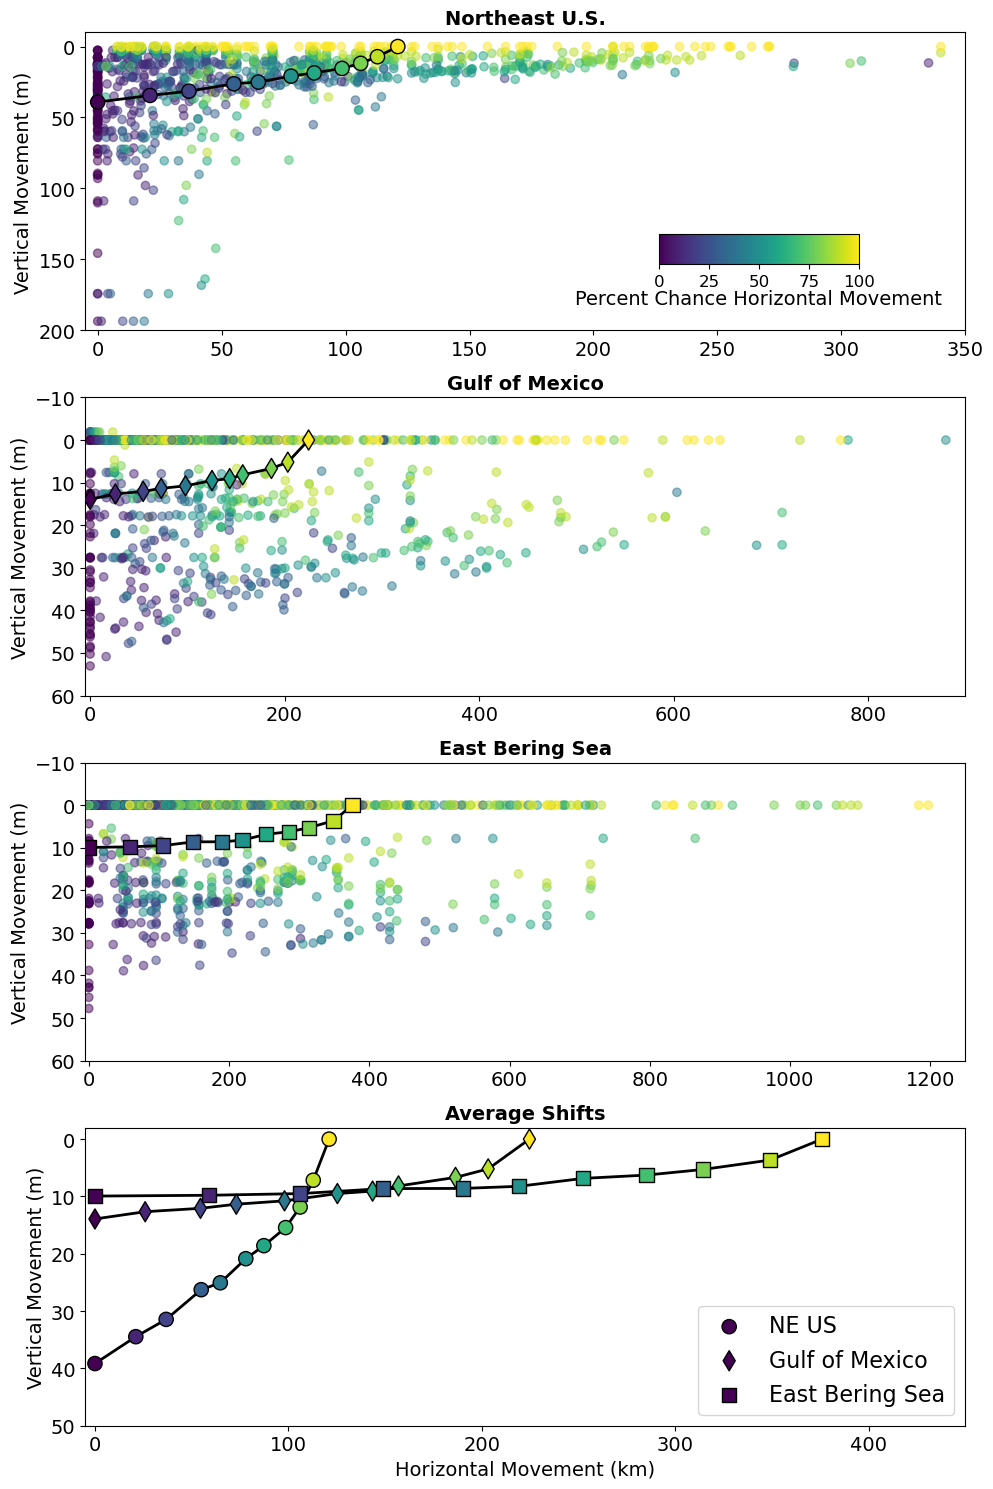

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = [10,15],)
n = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for i in range(100):
    ax[0].scatter(total_horiz50neus[i,:],total_depth50neus[i,:]-5, c = n, cmap = 'viridis',alpha =0.5)
ax[0].scatter(np.nanmean(total_horiz50neus[:,:],0),np.nanmean(total_depth50neus[:,:]-5,0),c = n, cmap = 'viridis', edgecolor = 'k', s = 105, zorder = 110)
ax[0].plot(np.nanmean(total_horiz50neus[:,:],0),np.nanmean(total_depth50neus[:,:]-5,0), linewidth = 2, color = 'k')
ax[0].set_xlim(-5,350)
ax[0].tick_params(labelsize = 14)
ax[0].set_ylim(200,-10)
ax[0].set_ylabel('Vertical Movement (m)', fontsize = 14)
#ax[0].set_xlabel('Horizontal Movement (km)', fontsize =14)
ax[0].set_title('Northeast U.S.', fontsize = 14, fontweight = 'bold')

for i in range(100):
    ax[1].scatter(total_horiz50gome[i,:],total_depth50gome[i,:]-5, c = n, cmap = 'viridis',alpha =0.5)
c = ax[1].scatter(np.nanmean(total_horiz50gome[:,:],0),np.nanmean(total_depth50gome[:,:]-5,0),c = n, cmap = 'viridis', edgecolor = 'k', s = 105, zorder = 110, marker = 'd')
ax[1].plot(np.nanmean(total_horiz50gome[:,:],0),np.nanmean(total_depth50gome[:,:]-5,0), linewidth = 2, color = 'k')
ax[1].set_xlim(-5,900)
ax[1].tick_params(labelsize = 14)
ax[1].set_ylim(60,-10)
#ax[0].set_ylabel('Vertical Movement (m)', fontsize = 14)
#ax[1].set_xlabel('Horizontal Movement (km)', fontsize =14)
ax[1].set_title('Gulf of Mexico', fontsize = 14, fontweight = 'bold')
ax[1].set_ylabel('Vertical Movement (m)', fontsize = 14)
#cbar = fig.colorbar(c, orientation="horizontal", pad=0.2, ax = ax[1])
#cbar.ax.tick_params(labelsize = 14)
trans = ax[1].get_xaxis_transform() # x in data untis, y in axes fraction
#ann = ax[1].annotate('Percent Horizontal', xy=(300, -.59 ), xycoords=trans, fontsize = 14)

for i in range(100):
    ax[2].scatter(total_horiz50ebes[i,:],total_depth50ebes[i,:]-5, c = n, cmap = 'viridis',alpha =0.5)
c = ax[2].scatter(np.nanmean(total_horiz50ebes[:,:],0),np.nanmean(total_depth50ebes[:,:]-5,0),c = n, cmap = 'viridis', edgecolor = 'k', s = 105, zorder = 110, marker = 's')
ax[2].plot(np.nanmean(total_horiz50ebes[:,:],0),np.nanmean(total_depth50ebes[:,:]-5,0), linewidth = 2, color = 'k')
ax[2].set_xlim(-5,1250)
ax[2].tick_params(labelsize = 14)
ax[2].set_ylim(60,-10)
#ax[0].set_ylabel('Vertical Movement (m)', fontsize = 14)
#ax[2].set_xlabel('Horizontal Movement (km)', fontsize =14)
ax[2].set_ylabel('Vertical Movement (m)', fontsize = 14)
ax[2].set_title('East Bering Sea', fontsize = 14, fontweight = 'bold')

cbaxes = fig.add_axes([0.66, .82, 0.2, 0.02])
cbar = plt.colorbar(c, cax = cbaxes, shrink = 0.25,orientation = 'horizontal')
cbar.set_label('Percent Chance Horizontal Movement', labelpad=0.01, y=.5, rotation=0, fontsize = 14)
cbar.ax.tick_params(labelsize=12) 

n = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

ax[3].scatter(np.nanmean(total_horiz50neus[:,:],0),np.nanmean(total_depth50neus[:,:]-5,0),c = n, cmap = 'viridis', edgecolor = 'k', s = 105, zorder = 2, label = 'NE US')
ax[3].plot(np.nanmean(total_horiz50neus[:,:],0),np.nanmean(total_depth50neus[:,:]-5,0), linewidth = 2, color = 'k', zorder =1)
ax[3].scatter(np.nanmean(total_horiz50gome[:,:],0),np.nanmean(total_depth50gome[:,:]-5,0),c = n, cmap = 'viridis', edgecolor = 'k', s = 105, marker = 'd', zorder = 4, label = 'Gulf of Mexico')
ax[3].plot(np.nanmean(total_horiz50gome[:,:],0),np.nanmean(total_depth50gome[:,:]-5,0), linewidth = 2, color = 'k')
ax[3].scatter(np.nanmean(total_horiz50ebes[:,:],0),np.nanmean(total_depth50ebes[:,:]-5,0),c = n, cmap = 'viridis', edgecolor = 'k', s = 105, marker = 's', zorder =5, label = 'East Bering Sea')
ax[3].plot(np.nanmean(total_horiz50ebes[:,:],0),np.nanmean(total_depth50ebes[:,:]-5,0), linewidth = 2, color = 'k')
ax[3].set_xlim(-5,450)
ax[3].tick_params(labelsize = 14)
ax[3].set_ylim(50,-2)
ax[3].set_ylabel('Vertical Movement (m)', fontsize = 14)
ax[3].set_xlabel('Horizontal Movement (km)', fontsize = 14)
#ax[0].set_xlabel('Horizontal Movement (km)', fontsize =14)
ax[3].set_title('Average Shifts', fontsize = 14, fontweight = 'bold')
ax[3].legend(loc = 'lower right', fontsize = 16)

plt.tight_layout()
